In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile, os

zip_path = '/content/drive/MyDrive/cleaned_dataset2 (2).zip'
extract_path = '/content/cleaned_dataset2'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted:", os.listdir(extract_path))


✅ Extracted: ['cleaned_dataset2']


In [ ]:
expected_folders = ['Train', 'Validate', 'Test']
contents = os.listdir(extract_path)
base_path = None

for folder in contents:
    candidate = os.path.join(extract_path, folder)
    if os.path.isdir(candidate):
        subfolders = os.listdir(candidate)
        print(f"🔍 Checking in: {candidate} →", subfolders)
        if all(f in subfolders for f in expected_folders):
            base_path = candidate
            break

if base_path is None:
    raise Exception("❌ Could not locate Train/Validate/Test folders.")

print("✅ Base path set to:", base_path)


🔍 Checking in: /content/cleaned_dataset2/cleaned_dataset2 → ['Test', 'Validate', 'Train']
✅ Base path set to: /content/cleaned_dataset2/cleaned_dataset2


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'Train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'Validate'),  # Capital "V"
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'Test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 2131 images belonging to 8 classes.
Found 303 images belonging to 8 classes.
Found 616 images belonging to 8 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune top 50 layers
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,709,547 (17.97 MB)

 Trainable params: 3,186,840 (12.16 MB)

 Non-trainable params: 1,522,707 (5.81 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_efficientnetb0_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.2910 - loss: 1.8759
Epoch 1: val_accuracy improved from -inf to 0.59076, saving model to /content/drive/MyDrive/best_efficientnetb0_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 83s 769ms/step - accuracy: 0.2932 - loss: 1.8719 - val_accuracy: 0.5908 - val_loss: 1.1591
Epoch 2/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.6519 - loss: 1.0587
Epoch 2: val_accuracy improved from 0.59076 to 0.70627, saving model to /content/drive/MyDrive/best_efficientnetb0_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 452ms/step - accuracy: 0.6522 - loss: 1.0578 - val_accuracy: 0.7063 - val_loss: 0.8222
Epoch 3/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.7314 - loss: 0.7841
Epoch 3: val_accuracy improved from 0.70627 to 0.78878, saving model to /content/drive/MyDrive/best_efficientnetb0_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 446ms/step - accuracy: 0.7316 - loss: 0.7834 - val_accuracy: 0.7888 - val_loss: 0.6322
Epoch 4/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8052 - loss: 0.5907
Epoch 4: val_accuracy improved from 0.78878 to 0.80858, saving model to /content/drive/MyDrive/best_efficientnetb0_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 40s 435ms/step - accuracy: 0.8049 - loss: 0.5910 - val_accuracy: 0.8086 - val_loss: 0.5642
Epoch 5/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8247 - loss: 0.5079
Epoch 5: val_accuracy improved from 0.80858 to 0.81848, saving model to /content/drive/MyDrive/best_efficientnetb0_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 447ms/step - accuracy: 0.8246 - loss: 0.5080 - val_accuracy: 0.8185 - val_loss: 0.5488
Epoch 6/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8471 - loss: 0.4453
Epoch 6: val_accuracy improved from 0.81848 to 0.83498, saving model to /content/drive/MyDrive/best_efficientnetb0_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 445ms/step - accuracy: 0.8471 - loss: 0.4455 - val_accuracy: 0.8350 - val_loss: 0.4951
Epoch 7/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8665 - loss: 0.3983
Epoch 7: val_accuracy did not improve from 0.83498
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 415ms/step - accuracy: 0.8666 - loss: 0.3981 - val_accuracy: 0.8251 - val_loss: 0.4867
Epoch 8/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8693 - loss: 0.3935
Epoch 8: val_accuracy did not improve from 0.83498
67/67 ━━━━━━━━━━━━━━━━━━━━ 27s 402ms/step - accuracy: 0.8693 - loss: 0.3933 - val_accuracy: 0.8317 - val_loss: 0.4681
Epoch 9/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8886 - loss: 0.3117
Epoch 9: val_accuracy did not improve from 0.83498
67/67 ━━━━━━━━━━━━━━━━━━━━ 27s 404ms/step - accuracy: 0.8886 - loss: 0.3117 - val_accuracy: 0.8284 - val_loss: 0.4609
Epoch 10/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9136 - loss: 0.2488
Epoch 10: val_accuracy did not

67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 436ms/step - accuracy: 0.9074 - loss: 0.2823 - val_accuracy: 0.8482 - val_loss: 0.4561
Epoch 12/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9177 - loss: 0.2318
Epoch 12: val_accuracy improved from 0.84818 to 0.85149, saving model to /content/drive/MyDrive/best_efficientnetb0_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - accuracy: 0.9177 - loss: 0.2317 - val_accuracy: 0.8515 - val_loss: 0.4703
Epoch 13/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9372 - loss: 0.1926
Epoch 13: val_accuracy did not improve from 0.85149
67/67 ━━━━━━━━━━━━━━━━━━━━ 38s 406ms/step - accuracy: 0.9371 - loss: 0.1927 - val_accuracy: 0.8383 - val_loss: 0.4659
Epoch 14/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9356 - loss: 0.1880
Epoch 14: val_accuracy did not improve from 0.85149
67/67 ━━━━━━━━━━━━━━━━━━━━ 27s 396ms/step - accuracy: 0.9356 - loss: 0.1881 - val_accuracy: 0.8482 - val_loss: 0.4684
Epoch 15/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9340 - loss: 0.1867
Epoch 15: val_accuracy did not improve from 0.85149
67/67 ━━━━━━━━━━━━━━━━━━━━ 27s 397ms/step - accuracy: 0.9341 - loss: 0.1866 - val_accuracy: 0.8482 - val_loss: 0.4834


In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {acc*100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.8274 - loss: 0.5360
✅ Test Accuracy: 85.88%


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 354ms/step


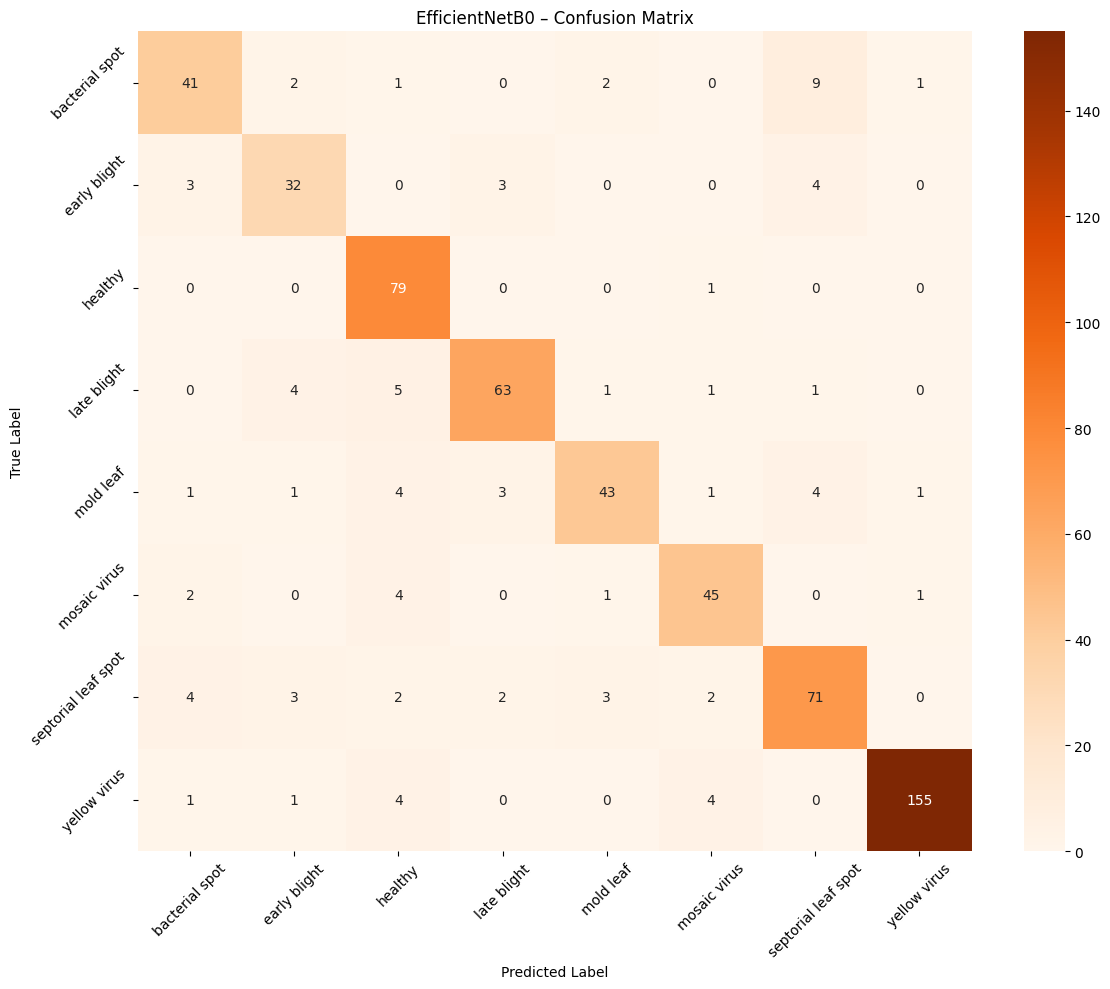

Classification Report:

                     precision    recall  f1-score   support

     bacterial spot       0.79      0.73      0.76        56
       early blight       0.74      0.76      0.75        42
            healthy       0.80      0.99      0.88        80
        late blight       0.89      0.84      0.86        75
          mold leaf       0.86      0.74      0.80        58
       mosaic virus       0.83      0.85      0.84        53
septorial leaf spot       0.80      0.82      0.81        87
       yellow virus       0.98      0.94      0.96       165

           accuracy                           0.86       616
          macro avg       0.84      0.83      0.83       616
       weighted avg       0.86      0.86      0.86       616



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("EfficientNetB0 – Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


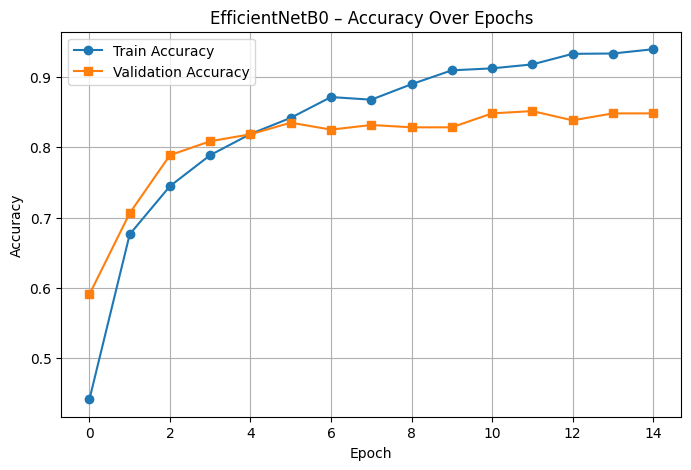

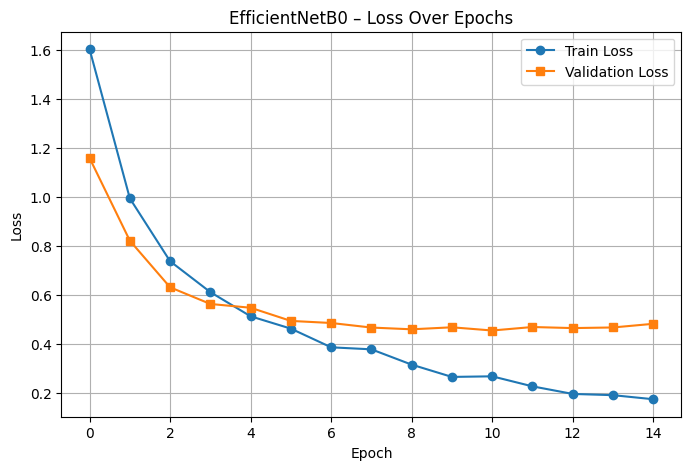

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('EfficientNetB0 – Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('EfficientNetB0 – Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/efficientnetb0_final_model.h5')
print("✅ Final model saved to Google Drive")


✅ Final model saved to Google Drive
